In [1]:
%load_ext autoreload
%autoreload 2

In [155]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy.io

In [6]:
from src.OED import *
from src.DQN import DQNConfig, DQN_OED
from src.GA import *
from pde.AdvectionEquation import *

## Evaluating models

In [14]:
pde_system = Advection2D(Adv2dModelConfig())
# gym_config = OEDGymConfig()
# gym_config.n_sensor = 2
# gym_config.n_components_rewards = 0.99

In [15]:
# dqn_config = DQNConfig()

### Old action space model : Seed 1, run 17

In [100]:
seed = 1
run_num = 17
model_name = f'trained_model/Adv_old/Advection2D_old_dqn_{run_num}_seed_{seed}.zip'
config_path = f'trained_model/Adv_old/Advection2D_old_dqn_{run_num}_seed_{seed}_config.pt'

In [101]:
configs = torch.load(config_path, weights_only=False)

# Access individual configs
gym_config = configs["gym_config"]
dqn_config = configs["dqn_config"]
tensorboard_dir = configs["tensorboard_log"]

In [102]:
gym_config.old_action_space = True
dqn_old = DQN_OED(seed, pde_system, gym_config, dqn_config, verbose=1)
dqn_old.load(model_name)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [103]:
old_a_all_ep_rewards, old_a_best_rewards, old_a_optimal_states_all = dqn_old.evaluate(50)

100%|██████████| 50/50 [00:00<00:00, 50.28it/s]


In [188]:
# plt.figure(figsize=(8, 6))
# plt.hist(old_a_best_rewards, bins=20, color='skyblue', edgecolor='black', alpha=0.75)
# plt.xlabel('Episode Best Reward')
# plt.ylabel('Frequency')
# plt.title('Distribution of Episode Best Rewards')
# plt.grid(True)
# plt.show()

## New Action space

In [105]:
seed = 1
run_num = 1
model_name = f'trained_model/Advection2D_new_dqn_{run_num}_seed_{seed}.zip'
config_path = f'trained_model/Advection2D_new_dqn_{run_num}_seed_{seed}_config.pt'

In [107]:
configs = torch.load(config_path, weights_only=False)

# Access individual configs
gym_config = configs["gym_config"]
dqn_config = configs["dqn_config"]
tensorboard_dir = configs["tensorboard_log"]

In [108]:
tensorboard_dir

'./tensorboard/DQN_1'

In [109]:
gym_config.old_action_space = False
dqn_new = DQN_OED(seed, pde_system, gym_config, dqn_config, verbose=1)
dqn_new.load(model_name)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [110]:
new_a_all_ep_rewards, new_a_best_rewards, new_a_optimal_states_all = dqn_new.evaluate(num_episodes=20)

100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


## GA

In [180]:
ga_filename = "GAResults/Advection2D_ga_3.mat"

In [181]:
ga_res = scipy.io.loadmat(ga_filename)

### MCTS

In [193]:
mcts_res = scipy.io.loadmat('MCTS_results/mcts_results.mat')

In [200]:
mcts_best_rew = mcts_res['best_rewards'].squeeze()

In [202]:
# plt.figure(figsize=(8, 6))
# plt.hist(mcts_best_rew, bins=20, color='skyblue', edgecolor='black', alpha=0.75)
# plt.xlabel('Episode Best Reward')
# plt.ylabel('Frequency')
# plt.title('Distribution of Episode Best Rewards')
# plt.grid(True)
# plt.show()

## Plots

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LightSource

In [116]:
env = dqn_old.env

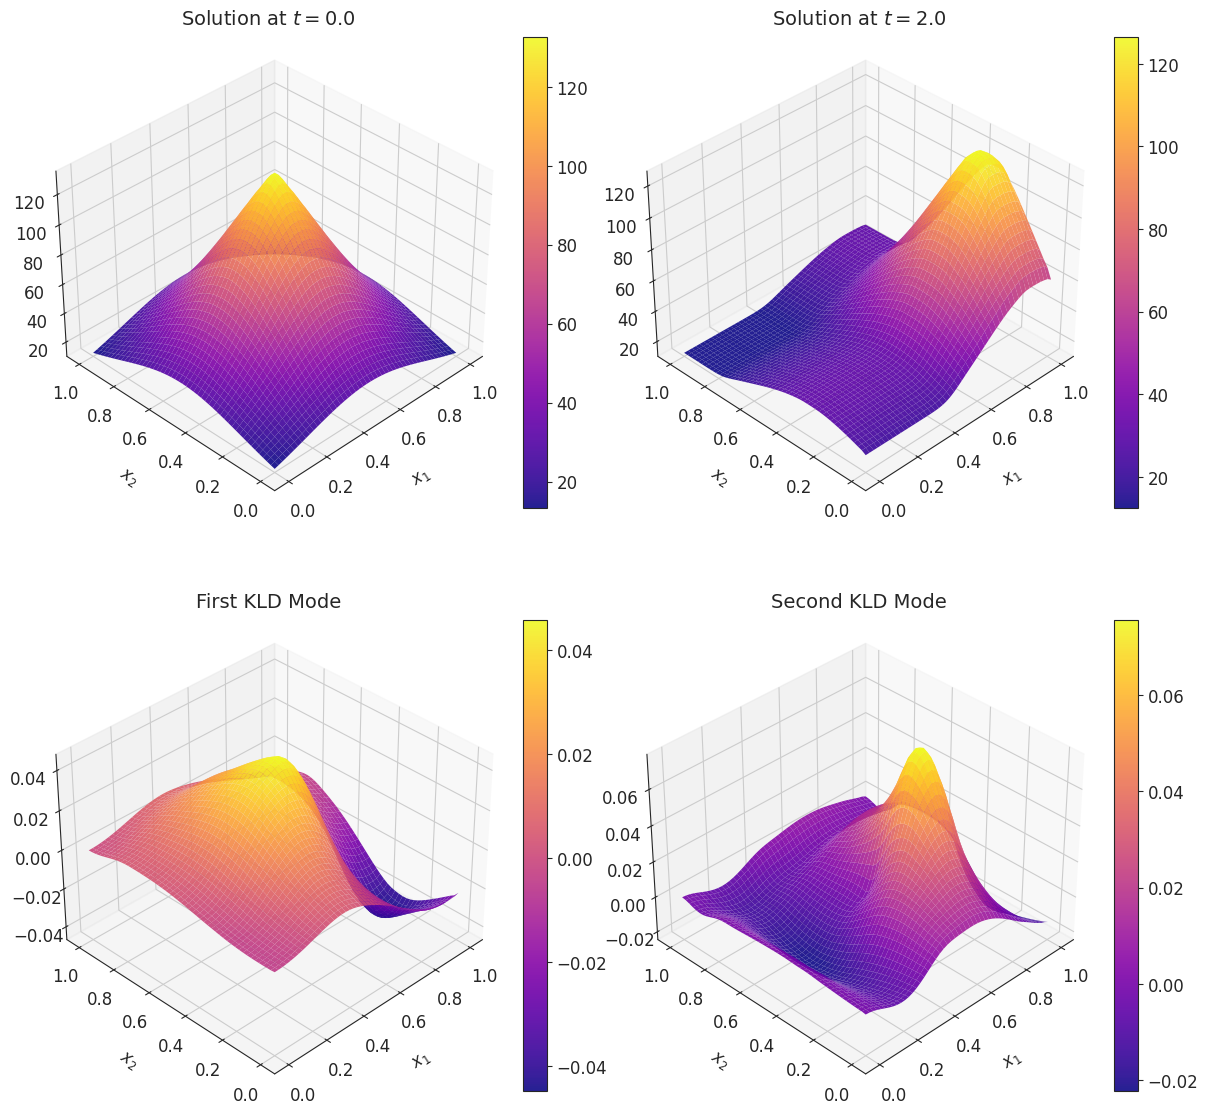

In [221]:
## Solution and Modes

fig = plt.figure(figsize=(12, 12)) 

x = np.linspace(0, 1, env.nx)
y = np.linspace(0, 1, env.ny)
X, Y = np.meshgrid(x, y)

datasets = [
    (env.pde_field[:, :, 0].T, rf"Solution at $t = {env.pde_system.t_steps[0]}$"),
    (env.pde_field[:, :, -1].T, rf"Solution at $t = {env.pde_system.t_steps[-1]}$"),
    (env.modes[:, 0].reshape(env.nx, env.ny).T, "First KLD Mode"),
    (env.modes[:, 1].reshape(env.nx, env.ny).T, "Second KLD Mode")
]

for i, (data, title) in enumerate(datasets):
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')
    
    ls = LightSource(azdeg=315, altdeg=-65)
    shaded = ls.shade(data, cmap=cm.coolwarm, vert_exag=0.1, blend_mode='soft')

    surf = ax.plot_surface(X, Y, data, cmap='plasma', edgecolor='none', alpha=0.9)
    
    ax.set_title(title, fontsize=14, pad=10)
    ax.set_xlabel(r'$x_1$', fontsize=12, labelpad=10)
    ax.set_ylabel(r'$x_2$', fontsize=12, labelpad=10)
    # ax.set_zlabel(r'$u(x_1, x_2)$', fontsize=12, labelpad=10)

    ax.view_init(elev=35, azim=-135)

    fig.colorbar(surf, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("3D_Adv2d_2x2.png", dpi=400, bbox_inches='tight')


plt.show()


In [122]:
# Old DQN: Training and reward

In [128]:
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd

In [145]:
# log_dir = 'trained_model/Adv_old/DQN_20/'
# tags = ['rollout/ep_rew_mean', 'train/loss']

# # Load the TensorBoard data
# ea = event_accumulator.EventAccumulator(
#     log_dir,
#     size_guidance={
#         event_accumulator.SCALARS: 0,
#     }
# )
# ea.Reload()

# available_tags = ea.Tags()['scalars']

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# data_rew_mean = ea.Scalars('rollout/ep_rew_mean')
# df_rew_mean = pd.DataFrame(data_rew_mean)

# ax1.plot(df_rew_mean.step, df_rew_mean.value, label='rollout/ep_rew_mean', color='blue')
# ax1.set_title('Rollout Episode Reward Mean')
# # ax1.set_xlabel('Step')
# ax1.set_ylabel('Reward')
# ax1.legend()

# data_loss = ea.Scalars('train/loss')
# df_loss = pd.DataFrame(data_loss)

# ax2.plot(df_loss.step, df_loss.value, label='train/loss', color='orange')
# ax2.set_title('Training Loss')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')
# ax2.set_yscale('log')
# ax2.legend()

# plt.tight_layout()
# # plt.savefig("old_dqn_adv2d.pdf", dpi=400, bbox_inches='tight')
# plt.show()

In [141]:
# New DQN: Training and reward

In [146]:
# log_dir = 'trained_model/Adv_new/DQN_1/'
# tags = ['rollout/ep_rew_mean', 'train/loss']

# # Load the TensorBoard data
# ea = event_accumulator.EventAccumulator(
#     log_dir,
#     size_guidance={
#         event_accumulator.SCALARS: 0,
#     }
# )
# ea.Reload()

# available_tags = ea.Tags()['scalars']

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# data_rew_mean = ea.Scalars('rollout/ep_rew_mean')
# df_rew_mean = pd.DataFrame(data_rew_mean)

# ax1.plot(df_rew_mean.step, df_rew_mean.value, label='rollout/ep_rew_mean', color='blue')
# ax1.set_title('Rollout Episode Reward Mean')
# # ax1.set_xlabel('Step')
# ax1.set_ylabel('Reward')
# ax1.legend()

# data_loss = ea.Scalars('train/loss')
# df_loss = pd.DataFrame(data_loss)

# ax2.plot(df_loss.step, df_loss.value, label='train/loss', color='orange')
# ax2.set_title('Training Loss')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')
# ax2.set_yscale('log')
# ax2.legend()

# plt.tight_layout()
# # plt.savefig("new_dqn_adv2d.pdf", dpi=400, bbox_inches='tight')
# plt.show()

In [147]:
# Reward distribution comparison

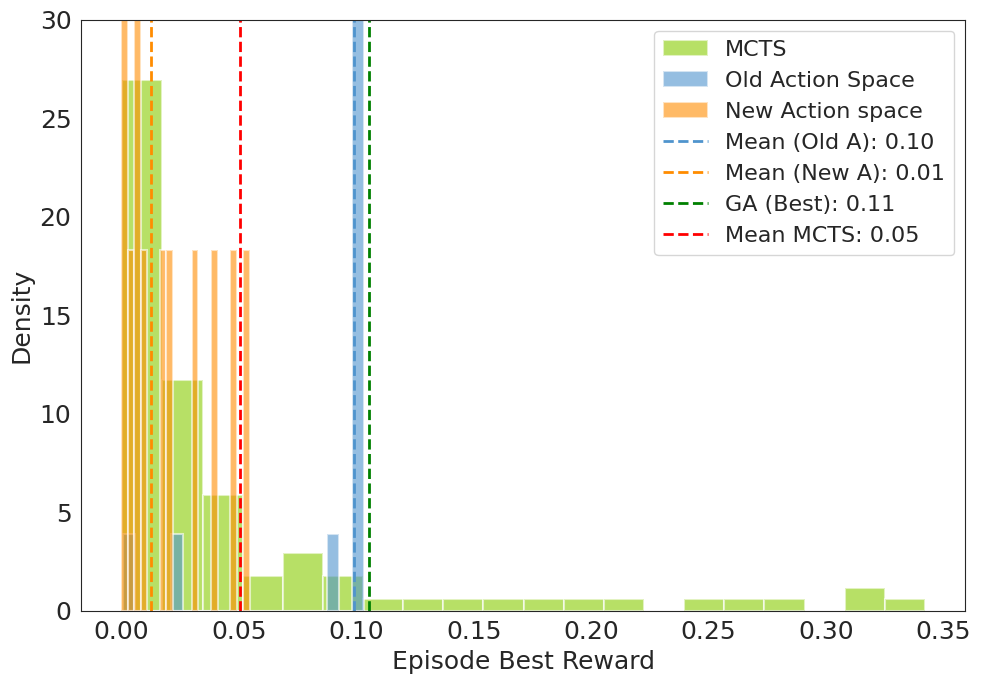

In [222]:
plt.figure(figsize=(10, 7))

plt.hist(mcts_best_rew, bins=20, 
         color='#8C00',
         edgecolor='white', 
         linewidth=1.5, 
         alpha=0.6, 
         density=True,  # Normalize densities
         label='MCTS')

plt.hist(old_a_best_rewards, bins=20, 
         color='#4F94CD',
         edgecolor='white', 
         linewidth=1.5, 
         alpha=0.6, 
         density=True,  # Normalize densities
         label='Old Action Space')

plt.hist(new_a_best_rewards, bins=20, 
         color='#FF8C00',
         edgecolor='white', 
         linewidth=1.5, 
         alpha=0.6, 
         density=True,  # Normalize densities
         label='New Action space')



mean_old = np.mean(old_a_best_rewards)
mean_new = np.mean(new_a_best_rewards)
mean_mcts = np.mean(mcts_best_rew)
ga_best = ga_res['best_fitness'][0][0]

plt.axvline(x=mean_old, color='#4F94CD', linestyle='--', linewidth=2, label=f'Mean (Old A): {mean_old:.2f}')
plt.axvline(x=mean_new, color='#FF8C00', linestyle='--', linewidth=2, label=f'Mean (New A): {mean_new:.2f}')
plt.axvline(x=ga_best, color='g', linestyle='--', linewidth=2, label=f'GA (Best): {ga_best:.2f}')
plt.axvline(x=mean_mcts, color='r', linestyle='--', linewidth=2, label=f'Mean MCTS: {mean_mcts:.2f}')

plt.xlabel('Episode Best Reward', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=16)
plt.ylim([0, 30])
plt.tight_layout()
plt.savefig("adv2d_res_hist.png", dpi=400, bbox_inches='tight')
plt.show()

In [219]:
# plt.figure(figsize=(12, 8))
# colors = {
#     'old_a': '#3498DB',  # Bright blue
#     'new_a': '#E74C3C',  # Crimson red
#     'mcts': '#2ECC71',   # Emerald green
#     'ga': '#9B59B6'      # Amethyst purple
# }

# plt.hist(mcts_best_rew, bins=20, 
#          color=colors['mcts'],
#          edgecolor='white', 
#          linewidth=1.5, 
#          alpha=0.3, 
#          density=True,  
#          label='MCTS')

# plt.hist(old_a_best_rewards, bins=20, 
#          color=colors['old_a'],
#          edgecolor='white', 
#          linewidth=1.5, 
#          alpha=0.9, 
#          density=True,  
#          label='Old Action Space')

# plt.hist(new_a_best_rewards, bins=20, 
#          color=colors['new_a'],
#          edgecolor='white', 
#          linewidth=1.5, 
#          alpha=0.8, 
#          density=True,  
#          label='New Action Space')

# mean_old = np.mean(old_a_best_rewards)
# mean_new = np.mean(new_a_best_rewards)
# mean_mcts = np.mean(mcts_best_rew)
# ga_best = ga_res['best_fitness'][0][0]

# plt.axvline(x=mean_old, color='b', linestyle='--', linewidth=2.5, 
#            label=f'Mean (Old): {mean_old:.2f}')
# plt.axvline(x=mean_new, color=colors['new_a'], linestyle='--', linewidth=2.5, 
#            label=f'Mean (New): {mean_new:.2f}')
# plt.axvline(x=mean_mcts, color=colors['mcts'], linestyle='--', linewidth=2.5, 
#            label=f'Mean (MCTS): {mean_mcts:.2f}')
# plt.axvline(x=ga_best, color=colors['ga'], linestyle='--', linewidth=2.5, 
#            label=f'GA Best: {ga_best:.2f}')

# plt.xlabel('Episode Best Reward', fontsize=20, fontweight='bold')
# plt.ylabel('Density', fontsize=20, fontweight='bold')
# plt.tick_params(axis='both', which='major', labelsize=16)

# plt.legend(fontsize=16, framealpha=0.9, ncol=2)
# plt.ylim([0, 25])

# plt.title('Distribution of Best Rewards', fontsize=22, pad=15)

# plt.tight_layout()
# plt.savefig("adv2d_res_hist.pdf", dpi=400, bbox_inches='tight')
# plt.show()

## Misc

In [187]:
# fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# im1 = axes[0, 0].imshow(env.pde_field[:, :, 0].T, origin='lower', extent=[0, 1, 0, 1])
# axes[0, 0].set_title(rf"Solution at $t = {adv_dqn_old_a.env.pde_system.t_steps[0]}$", fontsize=12)
# axes[0, 0].set_xlabel(r'$x_1$', fontsize=12)
# axes[0, 0].set_ylabel(r'$x_2$', fontsize=12)
# cbar1 = fig.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)
# cbar1.ax.tick_params(labelsize=10)

# im2 = axes[0, 1].imshow(env.pde_field[:, :, -1].T, origin='lower', extent=[0, 1, 0, 1])
# axes[0, 1].set_title(rf"Solution at $t = {adv_dqn_old_a.env.pde_system.t_steps[-1]}$", fontsize=12)
# axes[0, 1].set_xlabel(r'$x_1$', fontsize=12)
# axes[0, 1].set_ylabel(r'$x_2$', fontsize=12)
# cbar2 = fig.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)
# cbar2.ax.tick_params(labelsize=10)

# im3 = axes[1, 0].imshow(env.modes[:, 0].reshape(env.nx, env.ny).T, origin='lower', extent=[0, 1, 0, 1])
# axes[1, 0].set_title(rf"First KLD Mode", fontsize=12)
# axes[1, 0].set_xlabel(r'$x_1$', fontsize=12)
# axes[1, 0].set_ylabel(r'$x_2$', fontsize=12)
# cbar3 = fig.colorbar(im3, ax=axes[1, 0], fraction=0.046, pad=0.04)
# cbar3.ax.tick_params(labelsize=10)

# im4 = axes[1, 1].imshow(env.modes[:, 1].reshape(env.nx, env.ny), origin='lower', extent=[0, 1, 0, 1])
# axes[1, 1].set_title(rf"Second KLD Mode", fontsize=12)
# axes[1, 1].set_xlabel(r'$x_1$', fontsize=12)
# axes[1, 1].set_ylabel(r'$x_2$', fontsize=12)
# cbar4 = fig.colorbar(im4, ax=axes[1, 1], fraction=0.046, pad=0.04)
# cbar4.ax.tick_params(labelsize=10)

# plt.tight_layout(pad=2)
# # plt.savefig("IB2dSol.pdf", dpi=400)

# plt.show()


In [186]:
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib import cm
# from matplotlib.colors import LightSource

# fig = plt.figure(figsize=(20, 6)) 

# x = np.linspace(0, 1, env.nx)
# y = np.linspace(0, 1, env.ny)
# X, Y = np.meshgrid(x, y)

# datasets = [
#     (env.pde_field[:, :, 0].T, rf"Solution at $t = {env.pde_system.t_steps[0]}$"),
#     (env.pde_field[:, :, -1].T, rf"Solution at $t = {env.pde_system.t_steps[-1]}$"),
#     (env.modes[:, 0].reshape(env.nx, env.ny).T, "First KLD Mode"),
#     (env.modes[:, 1].reshape(env.nx, env.ny).T, "Second KLD Mode")
# ]

# for i, (data, title) in enumerate(datasets):
#     ax = fig.add_subplot(1, 4, i + 1, projection='3d')
    
#     ls = LightSource(azdeg=315, altdeg=65)
#     shaded = ls.shade(data, cmap=cm.coolwarm, vert_exag=0.1, blend_mode='soft')

#     surf = ax.plot_surface(X, Y, data, cmap='plasma', edgecolor='none', alpha=0.9)

#     ax.set_title(title, fontsize=14, pad=10)
#     ax.set_xlabel(r'$x_1$', fontsize=12, labelpad=5)
#     ax.set_ylabel(r'$x_2$', fontsize=12, labelpad=5)

#     ax.view_init(elev=30, azim=-130)

#     fig.colorbar(surf, ax=ax, fraction=0.035, pad=0.02)

# # plt.savefig("3D_Adv2d_modes.pdf", dpi=400, bbox_inches='tight')
# plt.show()
